In [2]:
import pandas as pd
import geopandas as gpd
from matplotlib import pyplot as plt
import numpy as np
import xgboost
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeRegressor
import shap
import warnings
warnings.filterwarnings("ignore")  # Silence some warnings
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
shap.initjs()

In [3]:
def set_timestep(df):
    df['Datetime'] = pd.to_datetime(df['time'], format="%Y-%m-%dT%H:%M:%S%z", utc=True)
    df = df.set_index('Datetime')
    return df

In [4]:
def ABS_SHAP(df_shap,df):
    #import matplotlib as plt
    # Make a copy of the input data
    shap_v = pd.DataFrame(df_shap)
    feature_list = df.columns
    shap_v.columns = feature_list
    df_v = df.copy().reset_index().drop('index',axis=1)

    # Determine the correlation in order to plot with different colors
    corr_list = list()
    for i in feature_list:
        b = np.corrcoef(shap_v[i],df_v[i])[1][0]
        corr_list.append(b)
    corr_df = pd.concat([pd.Series(feature_list),pd.Series(corr_list)],axis=1).fillna(0)
    # Make a data frame. Column 1 is the feature, and Column 2 is the correlation coefficient
    corr_df.columns  = ['Variable','Corr']
    corr_df['Sign'] = np.where(corr_df['Corr']>0,'red','blue')

    # Plot it
    shap_abs = np.abs(shap_v)
    k=pd.DataFrame(shap_abs.mean()).reset_index()
    k.columns = ['Variable','SHAP_abs']
    k2 = k.merge(corr_df,left_on = 'Variable',right_on='Variable',how='inner')
    k2 = k2.sort_values(by='SHAP_abs',ascending = True)
    colorlist = k2['Sign']
    ax = k2.plot.barh(x='Variable',y='SHAP_abs',color = colorlist, figsize=(5,6),legend=False)
    ax.set_xlabel("SHAP Value (Red = Positive Impact)")

In [108]:
folder_report = r'G:\Dyski współdzielone\DATA SCIENCE\Data Analysis\CustomerPanel\PM_weather_factors'
features = ['temperature', 'windSpeed', 'windBearing', 'humidity', 'pressure']
df = pd.read_csv(fr'{folder_report}\Data\CP_exampe_data_All.csv')
df = df.dropna(subset = features)
df_ts = set_timestep(df)
df_ts = df_ts.resample('3h').mean()
df_ts

,Unnamed: 0,id,pm1,pm10,pm25,no2,o3,temperature,windSpeed,windBearing,humidity,pressure
Datetime,,,,,,,,,,,,
2021-11-03 21:00:00+00:00,15165.645570,47624.518987,11.926835,23.395823,18.375443,42.966000,32.602000,6.990380,6.838987,116.388228,90.198861,1007.590000
2021-11-04 00:00:00+00:00,15167.645570,47624.518987,10.953460,21.114768,16.806920,35.068667,39.542667,7.310253,8.782278,106.790084,88.835527,1006.136878
2021-11-04 03:00:00+00:00,15170.645570,47624.518987,8.805148,16.694937,13.432996,35.695333,36.618667,7.569241,11.821688,107.204641,86.332996,1004.241055
2021-11-04 06:00:00+00:00,15197.412500,47562.495833,8.656250,15.825792,12.753292,49.233333,28.303889,9.143958,11.709833,106.203250,84.418042,1002.332417
2021-11-04 09:00:00+00:00,15171.655462,47603.592437,6.768487,11.985294,9.660126,42.196250,31.014375,12.561050,15.437227,124.550588,79.717101,1001.125630
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-18 09:00:00+00:00,17065.122137,51982.996183,32.929504,43.113588,38.727672,36.781282,29.745897,6.360153,20.545725,264.174733,75.788931,1025.036908
2021-11-18 12:00:00+00:00,17044.321839,51849.183908,32.725862,42.397854,38.146590,44.776410,27.862564,6.432414,20.729042,269.801724,73.546705,1024.669387
2021-11-18 15:00:00+00:00,17047.321839,51849.183908,37.428429,52.913410,45.543027,49.013590,16.924615,5.600843,17.067126,263.765517,78.112107,1024.837050


In [109]:
directions = np.array('N NE E SE S SW W NW'.split())
bins = np.arange(0, 360, 45)
df_ts['windBearing'] = directions[np.digitize(df_ts['windBearing'], bins) - 1]
weekends = np.where((df_ts.index.day_name() == 'Saturday') | (df_ts.index.day_name() == 'Sunday'))
weekends = np.asarray(weekends).flatten()
weekdays = np.where((df_ts.index.day_name() != 'Saturday') & (df_ts.index.day_name() != 'Sunday'))
weekdays = np.asarray(weekdays).flatten()
df_ts['WeekEnds'] = 0
df_ts['WeekEnds'][weekends] = 1
df_ts['WeekDays'] = 0
df_ts['WeekDays'][weekdays] = 1
df_ts


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Unnamed: 0,id,pm1,pm10,pm25,no2,o3,temperature,windSpeed,windBearing,humidity,pressure,WeekEnds,WeekDays
Datetime,,,,,,,,,,,,,,
2021-11-03 21:00:00+00:00,15165.645570,47624.518987,11.926835,23.395823,18.375443,42.966000,32.602000,6.990380,6.838987,E,90.198861,1007.590000,0,1
2021-11-04 00:00:00+00:00,15167.645570,47624.518987,10.953460,21.114768,16.806920,35.068667,39.542667,7.310253,8.782278,E,88.835527,1006.136878,0,1
2021-11-04 03:00:00+00:00,15170.645570,47624.518987,8.805148,16.694937,13.432996,35.695333,36.618667,7.569241,11.821688,E,86.332996,1004.241055,0,1
2021-11-04 06:00:00+00:00,15197.412500,47562.495833,8.656250,15.825792,12.753292,49.233333,28.303889,9.143958,11.709833,E,84.418042,1002.332417,0,1
2021-11-04 09:00:00+00:00,15171.655462,47603.592437,6.768487,11.985294,9.660126,42.196250,31.014375,12.561050,15.437227,E,79.717101,1001.125630,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-18 09:00:00+00:00,17065.122137,51982.996183,32.929504,43.113588,38.727672,36.781282,29.745897,6.360153,20.545725,SW,75.788931,1025.036908,0,1
2021-11-18 12:00:00+00:00,17044.321839,51849.183908,32.725862,42.397854,38.146590,44.776410,27.862564,6.432414,20.729042,SW,73.546705,1024.669387,0,1
2021-11-18 15:00:00+00:00,17047.321839,51849.183908,37.428429,52.913410,45.543027,49.013590,16.924615,5.600843,17.067126,SW,78.112107,1024.837050,0,1


In [110]:
hours = pd.get_dummies(df_ts.index.hour, prefix='hour')
wind_classes = pd.get_dummies(df_ts['windBearing'].values)
for_removal = ['windBearing', 'Unnamed: 0', 'id', 'pm1', 'pm25', 'no2', 'o3']
df_ts = df_ts.drop(for_removal, axis=1)
df_ts = df_ts.reset_index()
df = pd.concat((df_ts, hours, wind_classes), axis=1)
df

,Datetime,pm10,temperature,windSpeed,humidity,pressure,WeekEnds,WeekDays,hour_0,hour_3,...,hour_12,hour_15,hour_18,hour_21,E,NE,S,SE,SW,W
0,2021-11-03 21:00:00+00:00,23.395823,6.990380,6.838987,90.198861,1007.590000,0,1,0,0,...,0,0,0,1,1,0,0,0,0,0
1,2021-11-04 00:00:00+00:00,21.114768,7.310253,8.782278,88.835527,1006.136878,0,1,1,0,...,0,0,0,0,1,0,0,0,0,0
2,2021-11-04 03:00:00+00:00,16.694937,7.569241,11.821688,86.332996,1004.241055,0,1,0,1,...,0,0,0,0,1,0,0,0,0,0
3,2021-11-04 06:00:00+00:00,15.825792,9.143958,11.709833,84.418042,1002.332417,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
4,2021-11-04 09:00:00+00:00,11.985294,12.561050,15.437227,79.717101,1001.125630,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116,2021-11-18 09:00:00+00:00,43.113588,6.360153,20.545725,75.788931,1025.036908,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
117,2021-11-18 12:00:00+00:00,42.397854,6.432414,20.729042,73.546705,1024.669387,0,1,0,0,...,1,0,0,0,0,0,0,0,1,0
118,2021-11-18 15:00:00+00:00,52.913410,5.600843,17.067126,78.112107,1024.837050,0,1,0,0,...,0,1,0,0,0,0,0,0,1,0
119,2021-11-18 18:00:00+00:00,52.584253,5.303678,18.074253,78.635709,1024.442682,0,1,0,0,...,0,0,1,0,0,0,0,0,1,0


In [111]:
Y = df['pm10']
X = df.drop(['Datetime', 'pm10'], axis=1)
final_features = df.columns.values
d_time = np.where(final_features == 'Datetime')[0][0]
pm10 = np.where(final_features == 'pm10')[0][0]
final_features = np.delete(final_features, [d_time, pm10], axis=0)
final_features

array(['temperature', 'windSpeed', 'humidity', 'pressure', 'WeekEnds',
       'WeekDays', 'hour_0', 'hour_3', 'hour_6', 'hour_9', 'hour_12',
       'hour_15', 'hour_18', 'hour_21', 'E', 'NE', 'S', 'SE', 'SW', 'W'],
      dtype=object)

In [112]:
#scaler = MaxAbsScaler()
#scaler = MinMaxScaler()
#scaler = StandardScaler()
#scaler.fit(X)
#X_scaled = scaler.transform(X)
X_scaled = X
X_scaled

,temperature,windSpeed,humidity,pressure,WeekEnds,WeekDays,hour_0,hour_3,hour_6,hour_9,hour_12,hour_15,hour_18,hour_21,E,NE,S,SE,SW,W
0,6.990380,6.838987,90.198861,1007.590000,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0
1,7.310253,8.782278,88.835527,1006.136878,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0
2,7.569241,11.821688,86.332996,1004.241055,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0
3,9.143958,11.709833,84.418042,1002.332417,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0
4,12.561050,15.437227,79.717101,1001.125630,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116,6.360153,20.545725,75.788931,1025.036908,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0
117,6.432414,20.729042,73.546705,1024.669387,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0
118,5.600843,17.067126,78.112107,1024.837050,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0
119,5.303678,18.074253,78.635709,1024.442682,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0


In [113]:
#model_Train = RandomForestRegressor(n_estimators=200, random_state=0, max_depth=10)
model_Train = DecisionTreeRegressor(random_state=0, max_depth=8)
model_Train.fit(X_scaled,Y)
Output = model_Train.predict(X_scaled)
MAE = sum(abs(Output - Y))/len(Y)
MSE = sum(pow((Output - Y),2))/len(Y)
Results = pd.DataFrame()
Results['Y'] = Y
Results['Output'] = Output
Results['Difference'] = Y - Output

[0.7056654831454248, 2.5806466728491655]

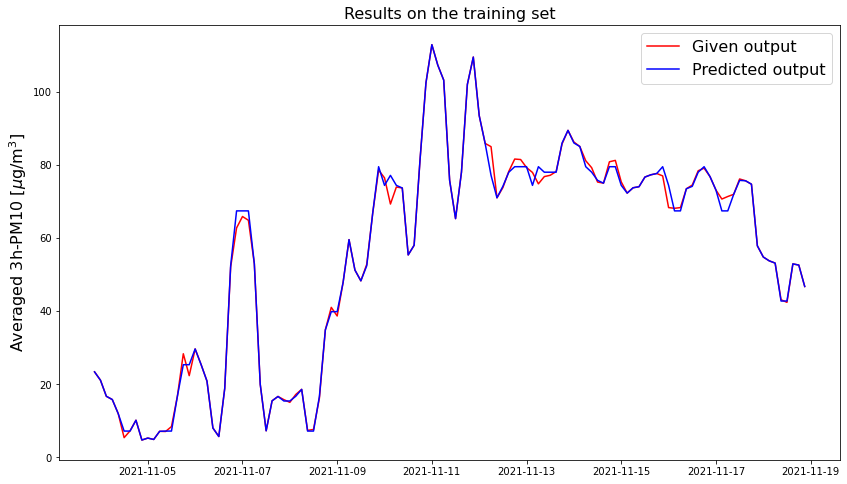

In [114]:
plt.figure(figsize=(14,8), facecolor='white')
plt.plot(df['Datetime'], Y, color='red', label='Given output')
plt.plot(df['Datetime'], Output, color='blue', label='Predicted output')
plt.ylabel('Averaged 3h-PM10 [$\mu$g/m$^3$]', fontsize=16)
plt.legend(fontsize=16)
plt.title('Results on the training set', fontsize=16)
[MAE, MSE]

In [115]:
X_train,X_test,Y_train,Y_test = train_test_split(X_scaled, Y, test_size=0.2)
[X_train.shape, X_test.shape, Y_train.shape, Y_test.shape]

[(96, 20), (25, 20), (96,), (25,)]

In [116]:
Y_train.reset_index(drop=True, inplace=True)
Y_test.reset_index(drop=True, inplace=True)

[1.84489188175618, 32.35943639980029]

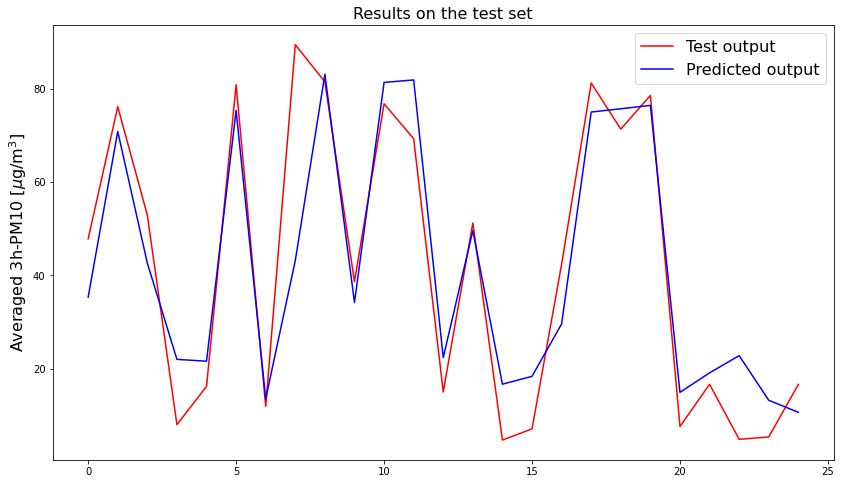

In [117]:
model_Test = RandomForestRegressor(n_estimators=200, random_state=0, max_depth=10)
model_Test.fit(X_train,Y_train)
Output_test = model_Test.predict(X_test)
MAE = sum(abs(Output_test - Y_test))/len(Y)
MSE = sum(pow((Output_test - Y_test),2))/len(Y)
plt.figure(figsize=(14,8), facecolor='white')
plt.plot(Y_test, color='red', label='Test output')
plt.plot(Output_test, color='blue', label='Predicted output')
plt.ylabel('Averaged 3h-PM10 [$\mu$g/m$^3$]', fontsize=16)
plt.legend(fontsize=16)
plt.title('Results on the test set', fontsize=16)
[MAE, MSE]

<BarContainer object of 20 artists>

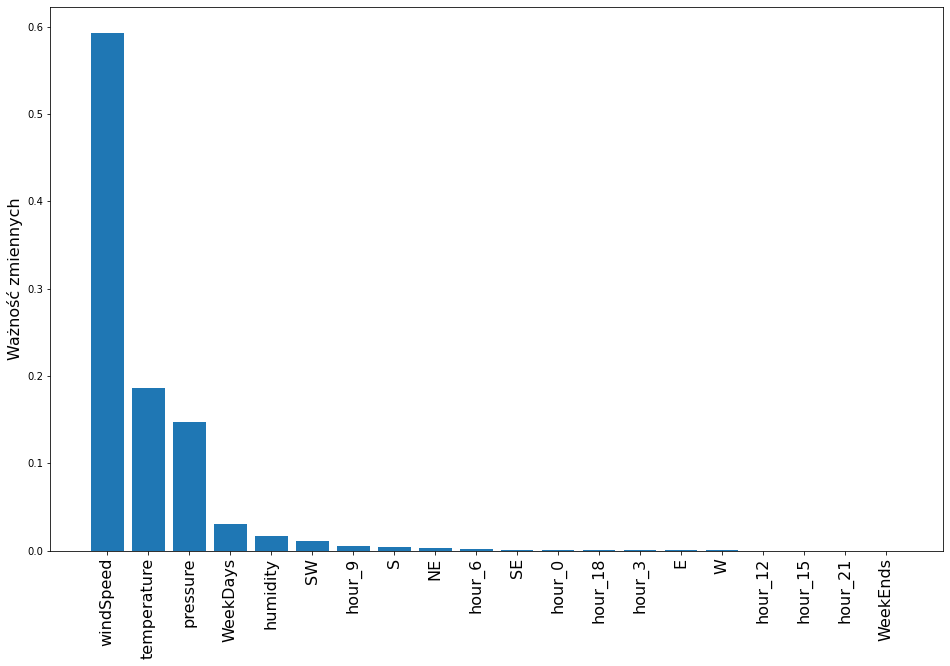

In [118]:
plt.figure(figsize=(16,10),facecolor='white')
importance = model_Train.feature_importances_
Sort_imp = np.sort(importance)
Sort_imp_desc = np.flip(Sort_imp)
Sort_imp_ind = np.argsort(importance)
Sort_imp_ind_desc = np.flip(Sort_imp_ind)
plt.ylabel('Ważność zmiennych', fontsize=16)
plt.xticks(rotation=90, fontsize=16)
plt.bar([final_features[Sort_imp_ind_desc[x]] for x in range(len(Sort_imp_desc))], Sort_imp_desc)

In [119]:
explainer = shap.Explainer(model_Train)
#explainer = shap.KernelExplainer(...)
#explainer = shap.DeepExplainer(...)
shap_values = explainer(X_scaled)
shap_values.base_values = shap_values.base_values[0][0] #Można też średnią z Output: Output.mean()

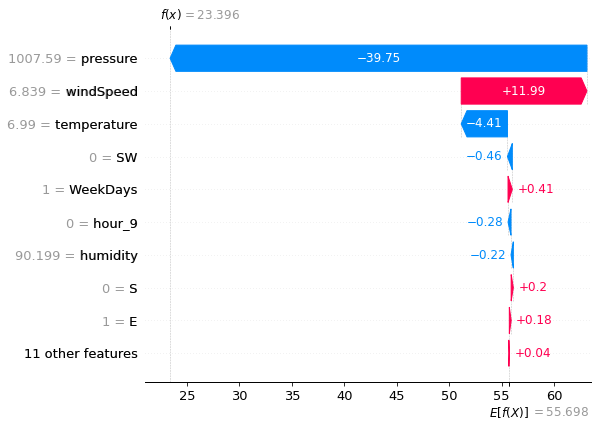

In [120]:
plt.figure(figsize=(16,10),facecolor='white')
shap.plots.waterfall(shap_values[0])

In [121]:
shap.plots.force(shap_values[0])

In [122]:
shap_values[0].values

array([-4.40784887e+00,  1.19865022e+01, -2.21804191e-01, -3.97454335e+01,
        0.00000000e+00,  4.07724723e-01, -2.85512930e-02, -4.16532376e-02,
       -5.41993365e-02, -2.82309391e-01,  4.65355234e-02,  3.99012140e-03,
        4.20646555e-02, -3.05164964e-03,  1.77059387e-01, -4.58667486e-02,
        2.03774613e-01,  9.36570555e-02, -4.62547593e-01,  3.01913084e-02])

In [123]:
shap_values[0].base_values + shap_values[0].values.sum()

23.395822784810115

In [124]:
shap.plots.force(shap_values[117])

In [125]:
# To jest wartość baseline
Output.mean()

55.69758901812486

In [126]:
[df.loc[0]['pm10'], Output[0]]

[23.395822784810125, 23.395822784810125]

invalid value encountered in true_divide
invalid value encountered in true_divide


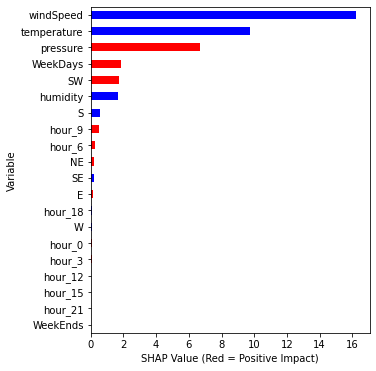

In [127]:
ABS_SHAP(shap_values.values,X_scaled)

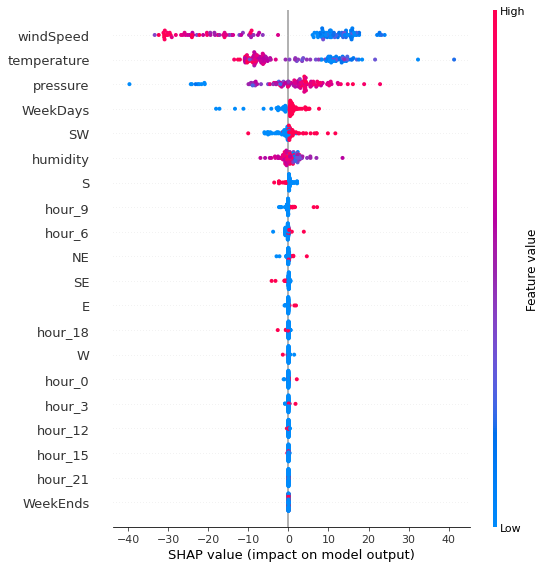

In [128]:
shap.summary_plot(shap_values.values, X_scaled)

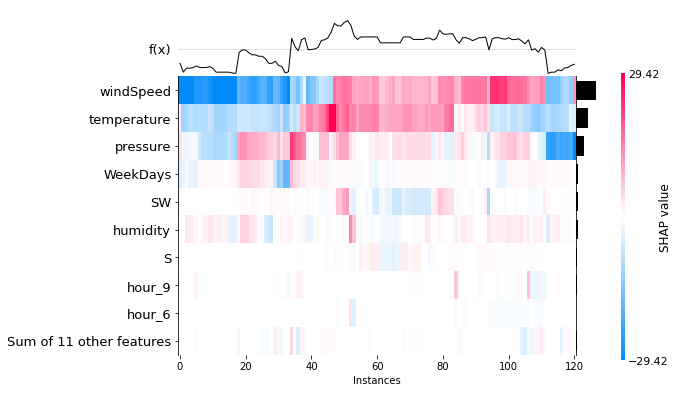

In [129]:
shap.plots.heatmap(shap_values)

In [130]:
shap.plots.force(shap_values)